# Correlations after clustering ASVs into OTUs

Given the difficulty of running correlations using very sparse ASV table generated with dada2 (min quality 20, only forward reads), we decided to try the clustering approach to group ASVs into OTUs. This comprises a higher level of resolution that could potentially work.

Qiime2 has nice tutorial on how to do this.

## Correlations with OTUs at 99% using SILVA (closed reference)


In [1]:
#kremling_expression_key = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
#sra_run_table_16s = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
#sra_run_table_rnaseq = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'
kremling_expression_key = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
sra_run_table_16s = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
sra_run_table_rnaseq = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'

dict_wallace_kremling_2018 = {}
kremling_expression_key_dict = {}

In [2]:
with open(kremling_expression_key, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split('\t')
        
        kremling_identifier = fields[0]
        wallace_identifier = fields[1]

        kremling_expression_key_dict[kremling_identifier] = wallace_identifier

In [3]:
import re

with open(sra_run_table_rnaseq, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('_')
        rnaseq_run_id = fields[0]
        sample_id = fields2[1]
        rnaseq_genotype = fields2[2]
        day = ''
        match = re.search(r'\d+', sample_id)
        unmatched_parts = re.split(r'\d+', sample_id)
        day_period = unmatched_parts[0]
        if match:
            day = int(match.group())
        if sample_id.startswith('LMA') and rnaseq_genotype != '#N/A':
            dict_wallace_kremling_2018[fields[11]] = {'run_accession_16s': '',
                                    'run_accession_rnaseq': rnaseq_run_id,
                                    'day': day,
                                    'day_period': day_period,
                                    'genotype_16s': '',
                                    'genotype_rnaseq': rnaseq_genotype}

In [4]:
rnaseq_samples_with_16s = 0

with open(sra_run_table_16s, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('.')
        metataxonomics_run_id = fields[0]
        day = int(fields2[1])
        day_period = fields2[0]
        for key, value in kremling_expression_key_dict.items():
            if value == fields[11]:
                if dict_wallace_kremling_2018[key]['day'] != day:
                    print('Big problem!')
                    print(day, dict_wallace_kremling_2018[key]['day'])
                    print(dict_wallace_kremling_2018[key])
                    print(value, fields[11], key)
                    exit(1)
                if dict_wallace_kremling_2018[key]['day_period'] != day_period:
                    print('Big problem!')
                    if key == '10343927_LMAN8_CML505_CAACAG':
                        #print("It's ok. I know this sample is problematic.")
                        continue
                    else:
                        print(day_period, dict_wallace_kremling_2018[key]['day_period'])
                        print(dict_wallace_kremling_2018[key])
                        print(value, fields[11], key)
                        exit(1)
                dict_wallace_kremling_2018[key]['run_accession_16s'] = metataxonomics_run_id
                rnaseq_samples_with_16s+=1

print(f'{rnaseq_samples_with_16s} sample pairs found.')

Big problem!
484 sample pairs found.


In [5]:
no_16s = 0
for key, value in dict_wallace_kremling_2018.items():
    if value['run_accession_16s'] == '':
        print(key, value)
        no_16s+=1
print(f'{no_16s} samples without 16S data.')

10343927_LMAN8_B73_CACACT {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5909633', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'B73'}
10343927_LMAN8_CML505_CAACAG {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5911345', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'CML505'}
2 samples without 16S data.


In [6]:
run2my_sample_id = {}

for key in dict_wallace_kremling_2018:
    if dict_wallace_kremling_2018[key]['run_accession_rnaseq']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_rnaseq']] = key
    if dict_wallace_kremling_2018[key]['run_accession_16s']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_16s']] = key

In [7]:
import pandas as pd

# Importing expression data from Kremling et al. 2018 (TPM matrix on Maize v5 using Salmon after cleaning with cutadapt)
kremling_expression_v5 = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')
#kremling_expression_v5 = pd.read_csv('/media/renato/SSD1TB/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')

# Rename column and reset the index
kremling_expression_v5.set_index('Name', inplace=True)

# Print the dataframe
kremling_expression_v5.head()

,SRR5909626,SRR5909627,SRR5909633,SRR5909635,SRR5909639,SRR5909642,SRR5909645,SRR5909653,SRR5909655,SRR5909665,...,SRR5912073,SRR5912081,SRR5912082,SRR5912083,SRR5912093,SRR5912094,SRR5912104,SRR5912105,SRR5912111,SRR5912116
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


In [8]:
# Rename the columns using the dictionary
kremling_expression_v5 = kremling_expression_v5.rename(columns=run2my_sample_id)
kremling_expression_v5.columns = [str(x) for x in kremling_expression_v5.columns]

kremling_expression_v5.head()

,10343927_LMAD26_CI21E_AAGTGG,10343264_LMAN26_CI21E_ATGAAC,10343927_LMAN8_B73_CACACT,10343264_LMAN26_B64_ACCAGT,10343262_LMAN8_B109_TGCTAT,10343262_LMAN8_B14A_CTCTCG,10343262_LMAN8_B57_CCTAAG,10343927_LMAD26_B77_TAATCG,10343262_LMAN8_B79_GCAGCC,10343927_LMAN8_CI187-2_GACGAT,...,10344826_LMAN8_I29_ACGTCT,10344823_LMAD8_IA2132_ACACGC,10343264_LMAD26_CML91_AACGCC,10344827_LMAN26_CML91_AATCCG,10344827_LMAN26_Ki21_AAGACA,10343927_LMAD26_Ki21_ACGTCT,10344826_LMAD8_E2558W_CGCAAC,10343927_LMAN8_E2558W_GAACCT,10344826_LMAD8_IDS69_CAGGAC,10343927_LMAN8_IDS69_ACATTA
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


### Importing feature table with ASV-generated OTU at 99% (SILVA)

ASVs generated from dada2 with reads quality 20, only forward reads, were clustered into OTUs at 99% using SILVA as reference (pre-processing steps are described on GitLab).

Here, I (RACS) import this table:

In [9]:
wallace_asvs_q20_fw_closedref_silva = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Qiime2/clustering/FeatureTable/cr99_q20_rv_feature-table.tsv',
                           sep='\t', comment='#')
#wallace_asvs_q20_fw_closedref_silva = pd.read_csv('/media/renato/SSD1TB/Projects/UGA_RACS/16S/Qiime2/clustering/q20_forward/close_ref_99/cr-wallace2018_forward_q20-99_feature-table/cr99_q20_rv_feature-table.tsv',
#                           sep='\t', comment='#')

# Rename column and reset the index
wallace_asvs_q20_fw_closedref_silva.rename(columns={'OTU ID': 'Name'}, inplace=True)
wallace_asvs_q20_fw_closedref_silva.set_index('Name', inplace=True)

# Print the dataframe
wallace_asvs_q20_fw_closedref_silva.head(n=2)

,SRR6665476,SRR6665477,SRR6665478,SRR6665479,SRR6665480,SRR6665481,SRR6665482,SRR6665483,SRR6665484,SRR6665485,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,SRR6666062,SRR6666063,SRR6666064,SRR6666065,SRR6666066,SRR6666067
Name,,,,,,,,,,,,,,,,,,,,,
JF127628.1.1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GQ009428.1.1352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
wallace_asvs_q20_fw_closedref_silva.shape

(1894, 592)

In [11]:
# Rename the columns using the dictionary
wallace_asvs_q20_fw_closedref_silva = wallace_asvs_q20_fw_closedref_silva.rename(columns=run2my_sample_id)
wallace_asvs_q20_fw_closedref_silva.columns = [str(x) for x in wallace_asvs_q20_fw_closedref_silva.columns]

In [12]:
wallace_asvs_q20_fw_closedref_silva.head()

,SRR6665476,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
JF127628.1.1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GQ009428.1.1352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JQ426823.1.1445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JF155101.1.1375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DQ336988.1.1491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
kremling_expression_v5_closedref = kremling_expression_v5.filter(items=wallace_asvs_q20_fw_closedref_silva.columns)

In [14]:
wallace_asvs_q20_fw_closedref_silva = wallace_asvs_q20_fw_closedref_silva.filter(items=kremling_expression_v5_closedref.columns)

In [15]:
print(kremling_expression_v5_closedref.shape)
kremling_expression_v5_closedref.head()

(39096, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.349820,0.0,0.000000,0.0,0.000000,0.359664,0.541724,0.000000,0.00000,0.0,...,2.11575,1.24155,1.24528,0.00000,0.0,0.00000,0.808996,0.743690,3.42920,0.00000
Zm00001eb371350_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371330_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371310_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371280_T001,0.441188,0.0,0.215403,0.0,0.817563,2.351130,0.885315,0.517418,1.56597,0.0,...,2.99848,2.70535,2.00021,2.23636,0.0,2.35318,2.974720,0.911501,1.52984,4.15375


In [16]:
print(wallace_asvs_q20_fw_closedref_silva.shape)
wallace_asvs_q20_fw_closedref_silva.head()

(1894, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
JF127628.1.1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GQ009428.1.1352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JQ426823.1.1445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JF155101.1.1375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DQ336988.1.1491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
if wallace_asvs_q20_fw_closedref_silva.columns.all() == kremling_expression_v5_closedref.columns.all():
    print('Columns are equal!')

Columns are equal!


In [18]:
def count_zeros(df, threshold=0.5):
    # Count the number of zeros in each row
    # If the number of zeros is greater than the threshold, remove the row
    threshold_int = int(df.shape[1] * threshold)
    print(f'Threshold: {threshold_int} (threshold * number of columns)')
    zero_counts = df.apply(lambda row: (row == 0).sum(), axis=1)
    return df[zero_counts < threshold_int]

In [19]:
wallace_asvs_q20_fw_closedref_silva_zeros_filtered = count_zeros(wallace_asvs_q20_fw_closedref_silva)
kremling_expression_v5_zeros_filtered = count_zeros(kremling_expression_v5_closedref)

Threshold: 241 (threshold * number of columns)
Threshold: 241 (threshold * number of columns)


In [20]:
print(wallace_asvs_q20_fw_closedref_silva_zeros_filtered.shape)
print(kremling_expression_v5_zeros_filtered.shape)

(7, 482)
(19953, 482)


In [21]:
wallace_asvs_q20_fw_closedref_silva_zeros_filtered

,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
JQ904048.1.1214,286.0,26752.0,288.0,31585.0,7985.0,1031.0,424.0,6752.0,12079.0,534.0,...,0.0,0.0,0.0,308.0,3406.0,961.0,118.0,0.0,0.0,619.0
JF177515.1.1306,636.0,7046.0,652.0,7960.0,85873.0,901.0,652.0,5983.0,7041.0,227.0,...,0.0,0.0,0.0,197.0,3584.0,4680.0,190.0,0.0,0.0,303.0
KF101313.1.1306,1000.0,6839.0,478.0,11097.0,12190.0,11492.0,12074.0,19987.0,2239.0,519.0,...,0.0,0.0,0.0,2957.0,14655.0,75048.0,2044.0,0.0,0.0,1542.0
FN421747.1.1368,2086.0,7930.0,13604.0,19280.0,8901.0,1051.0,667.0,752.0,14335.0,285.0,...,0.0,0.0,0.0,2362.0,12959.0,478.0,9602.0,0.0,0.0,227.0
MH337967.1.1252,1351.0,5537.0,10010.0,13543.0,6101.0,766.0,407.0,446.0,9845.0,200.0,...,0.0,0.0,0.0,1775.0,10874.0,293.0,6294.0,0.0,0.0,193.0
HM487994.1.1230,184.0,10256.0,152.0,8088.0,6904.0,903.0,123.0,452.0,2735.0,0.0,...,0.0,0.0,0.0,526.0,1881.0,565.0,1773.0,0.0,0.0,185.0
AAAA02020714.1.1202,4494.0,7158.0,47516.0,12429.0,5135.0,4201.0,1389.0,3836.0,1433.0,229.0,...,0.0,0.0,0.0,731.0,55388.0,2754.0,19631.0,0.0,0.0,5564.0


Taxonomy:

| ID | Taxonomy info |
|----|---------------|
| AAAA02020714.1.1202 | Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;Oryza sativa Indica Group (long-grained rice) |
| KF101313.1.1306	 | Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;uncultured bacterium |
| N421747.1.1368	 | Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;uncultured bacterium |
| MH337967.1.1252	 | Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Novosphingobium;Novosphingobium sp. |
| JF177515.1.1306 | Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Methylobacterium-Methylorubrum;uncultured bacterium |
| JQ904048.1.1214 | Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Methylobacterium-Methylorubrum;Methylorubrum rhodesianum |
| HM487994.1.1230 | Bacteria;Bacteroidota;Bacteroidia;Cytophagales;Hymenobacteraceae;Hymenobacter;uncultured bacterium |


## Correlations with OTUs at 99% using SILVA (open reference)

An alternative to closed reference is open-reference, where those sequences not clustering with the reference sequences are grouped separately.

In [22]:
kremling_expression_key = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
sra_run_table_16s = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
sra_run_table_rnaseq = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'

dict_wallace_kremling_2018 = {}
kremling_expression_key_dict = {}

In [23]:
with open(kremling_expression_key, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split('\t')
        
        kremling_identifier = fields[0]
        wallace_identifier = fields[1]

        kremling_expression_key_dict[kremling_identifier] = wallace_identifier

In [24]:
import re

with open(sra_run_table_rnaseq, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('_')
        rnaseq_run_id = fields[0]
        sample_id = fields2[1]
        rnaseq_genotype = fields2[2]
        day = ''
        match = re.search(r'\d+', sample_id)
        unmatched_parts = re.split(r'\d+', sample_id)
        day_period = unmatched_parts[0]
        if match:
            day = int(match.group())
        if sample_id.startswith('LMA') and rnaseq_genotype != '#N/A':
            dict_wallace_kremling_2018[fields[11]] = {'run_accession_16s': '',
                                    'run_accession_rnaseq': rnaseq_run_id,
                                    'day': day,
                                    'day_period': day_period,
                                    'genotype_16s': '',
                                    'genotype_rnaseq': rnaseq_genotype}

In [25]:
rnaseq_samples_with_16s = 0

with open(sra_run_table_16s, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('.')
        metataxonomics_run_id = fields[0]
        day = int(fields2[1])
        day_period = fields2[0]
        for key, value in kremling_expression_key_dict.items():
            if value == fields[11]:
                if dict_wallace_kremling_2018[key]['day'] != day:
                    print('Big problem!')
                    print(day, dict_wallace_kremling_2018[key]['day'])
                    print(dict_wallace_kremling_2018[key])
                    print(value, fields[11], key)
                    exit(1)
                if dict_wallace_kremling_2018[key]['day_period'] != day_period:
                    print('Big problem!')
                    if key == '10343927_LMAN8_CML505_CAACAG':
                        #print("It's ok. I know this sample is problematic.")
                        continue
                    else:
                        print(day_period, dict_wallace_kremling_2018[key]['day_period'])
                        print(dict_wallace_kremling_2018[key])
                        print(value, fields[11], key)
                        exit(1)
                dict_wallace_kremling_2018[key]['run_accession_16s'] = metataxonomics_run_id
                rnaseq_samples_with_16s+=1

print(f'{rnaseq_samples_with_16s} sample pairs found.')

Big problem!
484 sample pairs found.


In [26]:
no_16s = 0
for key, value in dict_wallace_kremling_2018.items():
    if value['run_accession_16s'] == '':
        print(key, value)
        no_16s+=1
print(f'{no_16s} samples without 16S data.')

10343927_LMAN8_B73_CACACT {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5909633', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'B73'}
10343927_LMAN8_CML505_CAACAG {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5911345', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'CML505'}
2 samples without 16S data.


In [27]:
run2my_sample_id = {}

for key in dict_wallace_kremling_2018:
    if dict_wallace_kremling_2018[key]['run_accession_rnaseq']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_rnaseq']] = key
    if dict_wallace_kremling_2018[key]['run_accession_16s']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_16s']] = key

In [28]:
import pandas as pd

# Importing expression data from Kremling et al. 2018 (TPM matrix on Maize v5 using Salmon after cleaning with cutadapt)
kremling_expression_v5 = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')
#kremling_expression_v5 = pd.read_csv('/media/renato/SSD1TB/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')

# Rename column and reset the index
kremling_expression_v5.set_index('Name', inplace=True)

# Print the dataframe
kremling_expression_v5.head()

,SRR5909626,SRR5909627,SRR5909633,SRR5909635,SRR5909639,SRR5909642,SRR5909645,SRR5909653,SRR5909655,SRR5909665,...,SRR5912073,SRR5912081,SRR5912082,SRR5912083,SRR5912093,SRR5912094,SRR5912104,SRR5912105,SRR5912111,SRR5912116
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


In [29]:
# Rename the columns using the dictionary
kremling_expression_v5 = kremling_expression_v5.rename(columns=run2my_sample_id)
kremling_expression_v5.columns = [str(x) for x in kremling_expression_v5.columns]

kremling_expression_v5.head()

,10343927_LMAD26_CI21E_AAGTGG,10343264_LMAN26_CI21E_ATGAAC,10343927_LMAN8_B73_CACACT,10343264_LMAN26_B64_ACCAGT,10343262_LMAN8_B109_TGCTAT,10343262_LMAN8_B14A_CTCTCG,10343262_LMAN8_B57_CCTAAG,10343927_LMAD26_B77_TAATCG,10343262_LMAN8_B79_GCAGCC,10343927_LMAN8_CI187-2_GACGAT,...,10344826_LMAN8_I29_ACGTCT,10344823_LMAD8_IA2132_ACACGC,10343264_LMAD26_CML91_AACGCC,10344827_LMAN26_CML91_AATCCG,10344827_LMAN26_Ki21_AAGACA,10343927_LMAD26_Ki21_ACGTCT,10344826_LMAD8_E2558W_CGCAAC,10343927_LMAN8_E2558W_GAACCT,10344826_LMAD8_IDS69_CAGGAC,10343927_LMAN8_IDS69_ACATTA
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


In [30]:
wallace_asvs_q20_fw_openref_silva = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Qiime2/clustering/FeatureTable/or99_q20_rv_feature-table.tsv',
                           sep='\t', comment='#')

# Rename column and reset the index
wallace_asvs_q20_fw_openref_silva.rename(columns={'OTU ID': 'Name'}, inplace=True)
wallace_asvs_q20_fw_openref_silva.set_index('Name', inplace=True)

# Print the dataframe
wallace_asvs_q20_fw_openref_silva.head(n=2)

,SRR6665476,SRR6665477,SRR6665478,SRR6665479,SRR6665480,SRR6665481,SRR6665482,SRR6665483,SRR6665484,SRR6665485,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,SRR6666062,SRR6666063,SRR6666064,SRR6666065,SRR6666066,SRR6666067
Name,,,,,,,,,,,,,,,,,,,,,
JF127628.1.1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GQ009428.1.1352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
wallace_asvs_q20_fw_openref_silva.shape

(3916, 592)

In [32]:
# Rename the columns using the dictionary
wallace_asvs_q20_fw_openref_silva = wallace_asvs_q20_fw_openref_silva.rename(columns=run2my_sample_id)
wallace_asvs_q20_fw_openref_silva.columns = [str(x) for x in wallace_asvs_q20_fw_openref_silva.columns]

In [33]:
wallace_asvs_q20_fw_openref_silva.head()

,SRR6665476,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
JF127628.1.1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GQ009428.1.1352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JQ426823.1.1445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JF155101.1.1375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DQ336988.1.1491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
kremling_expression_v5_openref = kremling_expression_v5.filter(items=wallace_asvs_q20_fw_openref_silva.columns)

In [35]:
wallace_asvs_q20_fw_openref_silva = wallace_asvs_q20_fw_openref_silva.filter(items=kremling_expression_v5_openref.columns)

In [36]:
print(kremling_expression_v5_openref.shape)
kremling_expression_v5_openref.head()

(39096, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.349820,0.0,0.000000,0.0,0.000000,0.359664,0.541724,0.000000,0.00000,0.0,...,2.11575,1.24155,1.24528,0.00000,0.0,0.00000,0.808996,0.743690,3.42920,0.00000
Zm00001eb371350_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371330_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371310_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371280_T001,0.441188,0.0,0.215403,0.0,0.817563,2.351130,0.885315,0.517418,1.56597,0.0,...,2.99848,2.70535,2.00021,2.23636,0.0,2.35318,2.974720,0.911501,1.52984,4.15375


In [37]:
print(wallace_asvs_q20_fw_openref_silva.shape)
wallace_asvs_q20_fw_openref_silva.head()

(3916, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
JF127628.1.1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GQ009428.1.1352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JQ426823.1.1445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JF155101.1.1375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DQ336988.1.1491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
if wallace_asvs_q20_fw_openref_silva.columns.all() == kremling_expression_v5_openref.columns.all():
    print('Columns are equal!')

Columns are equal!


In [39]:
def count_zeros(df, threshold=0.5):
    # Count the number of zeros in each row
    # If the number of zeros is greater than the threshold, remove the row
    threshold_int = int(df.shape[1] * threshold)
    print(f'Threshold: {threshold_int} (threshold * number of columns)')
    zero_counts = df.apply(lambda row: (row == 0).sum(), axis=1)
    return df[zero_counts < threshold_int]

In [40]:
wallace_asvs_q20_fw_openref_silva_zeros_filtered = count_zeros(wallace_asvs_q20_fw_openref_silva)
kremling_expression_v5_openref_zeros_filtered = count_zeros(kremling_expression_v5_openref)

Threshold: 241 (threshold * number of columns)
Threshold: 241 (threshold * number of columns)


In [41]:
print(wallace_asvs_q20_fw_openref_silva_zeros_filtered.shape)
print(kremling_expression_v5_openref_zeros_filtered.shape)

(10, 482)
(19953, 482)


In [42]:
wallace_asvs_q20_fw_openref_silva_zeros_filtered.index

Index(['JQ904048.1.1214', 'JF177515.1.1306', 'KF101313.1.1306',
       'FN421747.1.1368', 'MH337967.1.1252', 'HM487994.1.1230',
       'AAAA02020714.1.1202', 'fa79d5937f424b58a27843dfff8bdcd4',
       '876139714249d7a0203594416545eda6', '52c0751a4259810b7c12be45c6597335'],
      dtype='object', name='Name')

Taxonomy:

| ID | Taxonomy info |
|----|---------------|
| AAAA02020714.1.1202 | Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;Oryza sativa Indica Group (long-grained rice) |
| KF101313.1.1306	 | Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;uncultured bacterium |
| N421747.1.1368	 | Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;uncultured bacterium |
| MH337967.1.1252	 | Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Novosphingobium;Novosphingobium sp. |
| JF177515.1.1306 | Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Methylobacterium-Methylorubrum;uncultured bacterium |
| JQ904048.1.1214 | Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Methylobacterium-Methylorubrum;Methylorubrum rhodesianum |
| HM487994.1.1230 | Bacteria;Bacteroidota;Bacteroidia;Cytophagales;Hymenobacteraceae;Hymenobacter;uncultured bacterium |
| fa79d5937f424b58a27843dfff8bdcd4 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas | 0.8876251961000278 |
| 52c0751a4259810b7c12be45c6597335 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae | 0.9974740279969132 |
| 876139714249d7a0203594416545eda6 | d__Bacteria; p__Actinobacteriota; c__Actinobacteria; o__Micrococcales; f__Microbacteriaceae; g__Microbacterium | 0.9801655748383464 |

## Correlations with OTUs at 99% (de novo clustering)

ASVs generated from dada2 with reads quality 20, only forward reads, after filtering out mit, chloroplast and euk, were clustered into OTUs at 99% using a de novo method (pre-processing steps are described on GitLab).

Here, I (RACS) import this table:

In [43]:
wallace_asvs_q20_fw_denovo99_silva = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Qiime2/clustering/FeatureTable/denovo_99_q20_rv_feature-table.tsv',
                           sep='\t', comment='#')

# Rename column and reset the index
wallace_asvs_q20_fw_denovo99_silva.rename(columns={'OTU ID': 'Name'}, inplace=True)
wallace_asvs_q20_fw_denovo99_silva.set_index('Name', inplace=True)

# Print the dataframe
print(wallace_asvs_q20_fw_denovo99_silva.shape)
wallace_asvs_q20_fw_denovo99_silva.head(n=2)

(2628, 592)


,SRR6665476,SRR6665477,SRR6665478,SRR6665479,SRR6665480,SRR6665481,SRR6665482,SRR6665483,SRR6665484,SRR6665485,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,SRR6666062,SRR6666063,SRR6666064,SRR6666065,SRR6666066,SRR6666067
Name,,,,,,,,,,,,,,,,,,,,,
e4ffe22db2a232dd24e7ffbfa2d1ba23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4f68b7bfd602c05c7cd9e1d80f725d45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Rename the columns using the dictionary
wallace_asvs_q20_fw_denovo99_silva = wallace_asvs_q20_fw_denovo99_silva.rename(columns=run2my_sample_id)
wallace_asvs_q20_fw_denovo99_silva.columns = [str(x) for x in wallace_asvs_q20_fw_denovo99_silva.columns]

wallace_asvs_q20_fw_denovo99_silva.head()

,SRR6665476,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
e4ffe22db2a232dd24e7ffbfa2d1ba23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4f68b7bfd602c05c7cd9e1d80f725d45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232ad9e267688a5d573112b4855bac96,0.0,7725.0,19673.0,69881.0,32448.0,24012.0,21961.0,18905.0,33460.0,5117.0,...,44390.0,0.0,53362.0,32806.0,98560.0,109502.0,30377.0,0.0,0.0,10378.0
eb52ebb75b429069a302bd34b5c9cd63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3d1dbdd280105f11319d47dec1bbe01e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
kremling_expression_v5_denovo99 = kremling_expression_v5.filter(items=wallace_asvs_q20_fw_denovo99_silva.columns)

In [46]:
wallace_asvs_q20_fw_denovo99_silva = wallace_asvs_q20_fw_denovo99_silva.filter(items=kremling_expression_v5_denovo99.columns)

In [47]:
print(kremling_expression_v5_denovo99.shape)
kremling_expression_v5_denovo99.head()

(39096, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.349820,0.0,0.000000,0.0,0.000000,0.359664,0.541724,0.000000,0.00000,0.0,...,2.11575,1.24155,1.24528,0.00000,0.0,0.00000,0.808996,0.743690,3.42920,0.00000
Zm00001eb371350_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371330_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371310_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371280_T001,0.441188,0.0,0.215403,0.0,0.817563,2.351130,0.885315,0.517418,1.56597,0.0,...,2.99848,2.70535,2.00021,2.23636,0.0,2.35318,2.974720,0.911501,1.52984,4.15375


In [48]:
print(wallace_asvs_q20_fw_denovo99_silva.shape)
wallace_asvs_q20_fw_denovo99_silva.head()

(2628, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
e4ffe22db2a232dd24e7ffbfa2d1ba23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4f68b7bfd602c05c7cd9e1d80f725d45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232ad9e267688a5d573112b4855bac96,7725.0,19673.0,69881.0,32448.0,24012.0,21961.0,18905.0,33460.0,5117.0,1014.0,...,0.0,0.0,0.0,6296.0,98560.0,109502.0,30377.0,0.0,0.0,10378.0
eb52ebb75b429069a302bd34b5c9cd63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3d1dbdd280105f11319d47dec1bbe01e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
if wallace_asvs_q20_fw_denovo99_silva.columns.all() == kremling_expression_v5_denovo99.columns.all():
    print('Columns are equal!')

Columns are equal!


In [50]:
wallace_asvs_q20_fw_denovo99_silva_zeros_filtered = count_zeros(wallace_asvs_q20_fw_denovo99_silva)
kremling_expression_v5_denovo99_zeros_filtered = count_zeros(kremling_expression_v5_denovo99)

Threshold: 241 (threshold * number of columns)
Threshold: 241 (threshold * number of columns)


In [51]:
print(wallace_asvs_q20_fw_denovo99_silva_zeros_filtered.shape)
print(kremling_expression_v5_denovo99_zeros_filtered.shape)

(9, 482)
(19953, 482)


In [52]:
wallace_asvs_q20_fw_denovo99_silva_zeros_filtered.index

Index(['232ad9e267688a5d573112b4855bac96', '1674323e4fe615dc003edd628305bc9f',
       'd7386797b5be1ee26245561ee11ce7d4', '015c66180ecdb90b731d72f74a541767',
       'd8fac1aa74436b8041e29a3237da7955', '089df82153e0fc89ce4dd33e2fb967a9',
       '876139714249d7a0203594416545eda6', '225bc1cb152b786927ca748b98403d94',
       'a6c946adedd20c184243c5a9580120c7'],
      dtype='object', name='Name')

Taxonomy:

| ID | Taxonomy info |
|----|---------------|
| 232ad9e267688a5d573112b4855bac96 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas | 0.9046232311280543 |
| 1674323e4fe615dc003edd628305bc9f | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae | 0.9981399823237278 |
| d8fac1aa74436b8041e29a3237da7955 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Beijerinckiaceae; g__Methylobacterium-Methylorubrum | 0.934485077586803 |
| d7386797b5be1ee26245561ee11ce7d4 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Beijerinckiaceae; g__Methylobacterium-Methylorubrum | 0.9452843145859641 |
| 225bc1cb152b786927ca748b98403d94 | d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__Hymenobacteraceae; g__Hymenobacter | 0.9979727897056238 |
| 876139714249d7a0203594416545eda6 | d__Bacteria; p__Actinobacteriota; c__Actinobacteria; o__Micrococcales; f__Microbacteriaceae; g__Microbacterium | 0.9801655748383464 |
| a6c946adedd20c184243c5a9580120c7 | d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales | 0.9986316010935418 |
| 089df82153e0fc89ce4dd33e2fb967a9 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas | 0.9945668726254755 |
| 015c66180ecdb90b731d72f74a541767 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Rhizobiaceae; g__Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium | 0.8336974343250252 |

## Correlations with OTUs at 97% (de novo clustering)

ASVs generated from dada2 with reads quality 20, only forward reads, were clustered into OTUs at 97% using a de novo method (pre-processing steps are described on GitLab).

Here, I (RACS) import this table:

In [53]:
wallace_asvs_q20_fw_denovo97_silva = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Qiime2/clustering/FeatureTable/denovo_97_q20_rv_feature-table.tsv',
                           sep='\t', comment='#')

# Rename column and reset the index
wallace_asvs_q20_fw_denovo97_silva.rename(columns={'OTU ID': 'Name'}, inplace=True)
wallace_asvs_q20_fw_denovo97_silva.set_index('Name', inplace=True)

# Print the dataframe
print(wallace_asvs_q20_fw_denovo97_silva.shape)
wallace_asvs_q20_fw_denovo97_silva.head(n=2)

(1277, 592)


,SRR6665476,SRR6665477,SRR6665478,SRR6665479,SRR6665480,SRR6665481,SRR6665482,SRR6665483,SRR6665484,SRR6665485,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,SRR6666062,SRR6666063,SRR6666064,SRR6666065,SRR6666066,SRR6666067
Name,,,,,,,,,,,,,,,,,,,,,
e4ffe22db2a232dd24e7ffbfa2d1ba23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4f68b7bfd602c05c7cd9e1d80f725d45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Rename the columns using the dictionary
wallace_asvs_q20_fw_denovo97_silva = wallace_asvs_q20_fw_denovo97_silva.rename(columns=run2my_sample_id)
wallace_asvs_q20_fw_denovo97_silva.columns = [str(x) for x in wallace_asvs_q20_fw_denovo97_silva.columns]

In [55]:
wallace_asvs_q20_fw_denovo97_silva.head()

,SRR6665476,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
e4ffe22db2a232dd24e7ffbfa2d1ba23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4f68b7bfd602c05c7cd9e1d80f725d45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232ad9e267688a5d573112b4855bac96,0.0,13538.0,55068.0,103357.0,94445.0,48809.0,26670.0,20909.0,41009.0,41676.0,...,45464.0,0.0,86537.0,42962.0,133335.0,114052.0,53169.0,0.0,0.0,18971.0
d4d4add6f159224c428e7a0c754dcd63,0.0,19.0,157.0,28.0,147.0,987.0,0.0,89.0,0.0,845.0,...,22.0,0.0,18.0,14.0,198.0,92.0,69.0,0.0,0.0,0.0
3d1dbdd280105f11319d47dec1bbe01e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
kremling_expression_v5_denovo97 = kremling_expression_v5.filter(items=wallace_asvs_q20_fw_denovo97_silva.columns)

In [57]:
wallace_asvs_q20_fw_denovo97_silva = wallace_asvs_q20_fw_denovo97_silva.filter(items=kremling_expression_v5_denovo97.columns)

In [58]:
print(kremling_expression_v5_denovo97.shape)
kremling_expression_v5_denovo97.head()

(39096, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.349820,0.0,0.000000,0.0,0.000000,0.359664,0.541724,0.000000,0.00000,0.0,...,2.11575,1.24155,1.24528,0.00000,0.0,0.00000,0.808996,0.743690,3.42920,0.00000
Zm00001eb371350_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371330_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371310_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371280_T001,0.441188,0.0,0.215403,0.0,0.817563,2.351130,0.885315,0.517418,1.56597,0.0,...,2.99848,2.70535,2.00021,2.23636,0.0,2.35318,2.974720,0.911501,1.52984,4.15375


In [59]:
print(wallace_asvs_q20_fw_denovo97_silva.shape)
wallace_asvs_q20_fw_denovo97_silva.head()

(1277, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
e4ffe22db2a232dd24e7ffbfa2d1ba23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4f68b7bfd602c05c7cd9e1d80f725d45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232ad9e267688a5d573112b4855bac96,13538.0,55068.0,103357.0,94445.0,48809.0,26670.0,20909.0,41009.0,41676.0,1858.0,...,0.0,0.0,0.0,12464.0,133335.0,114052.0,53169.0,0.0,0.0,18971.0
d4d4add6f159224c428e7a0c754dcd63,19.0,157.0,28.0,147.0,987.0,0.0,89.0,0.0,845.0,41.0,...,0.0,0.0,0.0,0.0,198.0,92.0,69.0,0.0,0.0,0.0
3d1dbdd280105f11319d47dec1bbe01e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
if wallace_asvs_q20_fw_denovo97_silva.columns.all() == kremling_expression_v5_denovo97.columns.all():
    print('Columns are equal!')

Columns are equal!


In [61]:
wallace_asvs_q20_fw_denovo97_silva_zeros_filtered = count_zeros(wallace_asvs_q20_fw_denovo97_silva)
kremling_expression_v5_denovo97_zeros_filtered = count_zeros(kremling_expression_v5_denovo97)

Threshold: 241 (threshold * number of columns)
Threshold: 241 (threshold * number of columns)


In [62]:
print(wallace_asvs_q20_fw_denovo97_silva_zeros_filtered.shape)
print(kremling_expression_v5_denovo97_zeros_filtered.shape)

(11, 482)
(19953, 482)


In [63]:
wallace_asvs_q20_fw_denovo97_silva_zeros_filtered.index

Index(['232ad9e267688a5d573112b4855bac96', 'b1bda8871b67d26c1b0c1ad6d5c57c56',
       'd256dc8e2d15b37c97e829c7f6fe5d23', 'd7386797b5be1ee26245561ee11ce7d4',
       'a6c946adedd20c184243c5a9580120c7', '015c66180ecdb90b731d72f74a541767',
       '9513fb99947860ebff7ca131f8cee160', 'd8fac1aa74436b8041e29a3237da7955',
       'acca42a5ffae1505efc844b610370e80', '876139714249d7a0203594416545eda6',
       '225bc1cb152b786927ca748b98403d94'],
      dtype='object', name='Name')

Taxonomy:

| ID | Taxonomy info |
|----|---------------|
| 232ad9e267688a5d573112b4855bac96 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas |
| d8fac1aa74436b8041e29a3237da7955 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Beijerinckiaceae; g__Methylobacterium-Methylorubrum |
| d7386797b5be1ee26245561ee11ce7d4 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Beijerinckiaceae; g__Methylobacterium-Methylorubrum |
| 225bc1cb152b786927ca748b98403d94 | d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__Hymenobacteraceae; g__Hymenobacter |
| 876139714249d7a0203594416545eda6 | d__Bacteria; p__Actinobacteriota; c__Actinobacteria; o__Micrococcales; f__Microbacteriaceae; g__Microbacterium |
| a6c946adedd20c184243c5a9580120c7 | d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales |
| 9513fb99947860ebff7ca131f8cee160 | d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Weeksellaceae; g__Chryseobacterium |
| 015c66180ecdb90b731d72f74a541767 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Rhizobiaceae; g__Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium |
| d256dc8e2d15b37c97e829c7f6fe5d23 | d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter |
| acca42a5ffae1505efc844b610370e80 | d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas |
| b1bda8871b67d26c1b0c1ad6d5c57c56 | d__Bacteria; p__Actinobacteriota; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Nocardioides |

In [64]:
wallace_asvs_q20_fw_denovo97_silva_zeros_filtered

,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
232ad9e267688a5d573112b4855bac96,13538.0,55068.0,103357.0,94445.0,48809.0,26670.0,20909.0,41009.0,41676.0,1858.0,...,0.0,0.0,0.0,12464.0,133335.0,114052.0,53169.0,0.0,0.0,18971.0
b1bda8871b67d26c1b0c1ad6d5c57c56,114.0,191.0,18823.0,161.0,130.0,0.0,325.0,536.0,205.0,0.0,...,0.0,0.0,0.0,301.0,468.0,2702.0,72.0,0.0,0.0,128.0
d256dc8e2d15b37c97e829c7f6fe5d23,74.0,0.0,27112.0,90.0,20.0,0.0,1029.0,1403.0,12.0,0.0,...,0.0,0.0,0.0,63.0,505.0,470.0,0.0,0.0,0.0,30.0
d7386797b5be1ee26245561ee11ce7d4,392.0,37685.0,399.0,44248.0,11092.0,1414.0,609.0,9471.0,17001.0,852.0,...,0.0,0.0,0.0,526.0,4849.0,1349.0,118.0,0.0,0.0,875.0
a6c946adedd20c184243c5a9580120c7,759.0,96.0,12615.0,2931.0,562.0,498.0,8570.0,674.0,353.0,90.0,...,0.0,0.0,0.0,935.0,241.0,65436.0,457.0,0.0,0.0,47919.0
015c66180ecdb90b731d72f74a541767,27.0,0.0,23787.0,104.0,399.0,0.0,1005.0,743.0,49.0,25.0,...,0.0,0.0,0.0,470.0,810.0,479.0,2976.0,0.0,0.0,200.0
9513fb99947860ebff7ca131f8cee160,92.0,236.0,29113.0,239.0,1505.0,166.0,803.0,1238.0,0.0,0.0,...,0.0,0.0,0.0,602.0,86.0,776.0,1227.0,0.0,0.0,162.0
d8fac1aa74436b8041e29a3237da7955,1333.0,11446.0,3295.0,22949.0,120770.0,2393.0,1295.0,9106.0,32376.0,1754.0,...,0.0,0.0,0.0,1037.0,5172.0,8277.0,190.0,0.0,0.0,407.0
acca42a5ffae1505efc844b610370e80,70.0,62.0,32.0,64.0,71.0,178.0,995.0,29.0,171.0,0.0,...,0.0,0.0,0.0,187.0,128.0,985.0,214.0,0.0,0.0,29029.0


In [65]:
kremling_expression_v5_denovo97_zeros_filtered.head(n=30)

,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.349820,0.000000,0.000000,0.000000,0.000000,0.359664,0.541724,0.000000,0.000000,0.00000,...,2.115750,1.241550,1.245280,0.00000,0.000000,0.00000,0.808996,0.743690,3.429200,0.00000
Zm00001eb371280_T001,0.441188,0.000000,0.215403,0.000000,0.817563,2.351130,0.885315,0.517418,1.565970,0.00000,...,2.998480,2.705350,2.000210,2.23636,0.000000,2.35318,2.974720,0.911501,1.529840,4.15375
Zm00001eb371250_T001,10.643500,5.696630,2.078610,0.492593,2.564040,3.686800,5.553050,4.743360,6.044550,4.99574,...,3.720200,5.221260,3.474330,7.19351,6.496340,5.80311,7.654820,4.397930,8.267150,12.06620
Zm00001eb371230_T001,0.000000,0.592570,0.475682,0.563641,0.000000,1.298020,0.000000,0.000000,2.593630,0.00000,...,2.837840,1.493580,0.000000,3.29241,0.874497,4.61920,0.000000,0.000000,0.000000,1.31041
Zm00001eb371180_T001,24.792600,22.290700,15.788600,21.202500,31.460900,25.849900,40.016500,29.076300,12.434700,12.64880,...,2.093160,13.219800,32.254500,30.96270,23.220700,19.16480,15.343600,14.104600,23.174400,20.29740
Zm00001eb371100_T001,4.276510,0.000000,0.000000,3.075810,5.033300,8.469190,4.754610,0.135552,0.000000,6.78129,...,0.000000,1.417480,0.000000,3.90583,2.904790,0.00000,0.346359,0.000000,1.923760,0.00000
Zm00001eb371080_T001,93.300400,64.678100,0.000000,52.234400,63.208700,144.350000,78.512500,21.178300,33.828500,23.54430,...,5.844270,7.689720,1.819340,61.02380,50.426500,49.94220,16.534900,22.108700,12.523500,2.69866
Zm00001eb371040_T001,0.000000,2.499490,4.302800,8.746540,2.476300,12.009900,1.310390,0.000000,0.000000,0.00000,...,0.000000,4.059440,0.000000,0.00000,1.149550,0.00000,0.000000,0.940823,0.953614,0.00000
Zm00001eb371020_T003,4.650000,2.610610,6.752760,3.034970,4.474150,4.447730,4.067340,3.705540,4.020620,4.89678,...,3.472860,5.025970,5.297450,4.43207,4.173710,4.16896,3.393790,4.598200,4.465130,4.89110


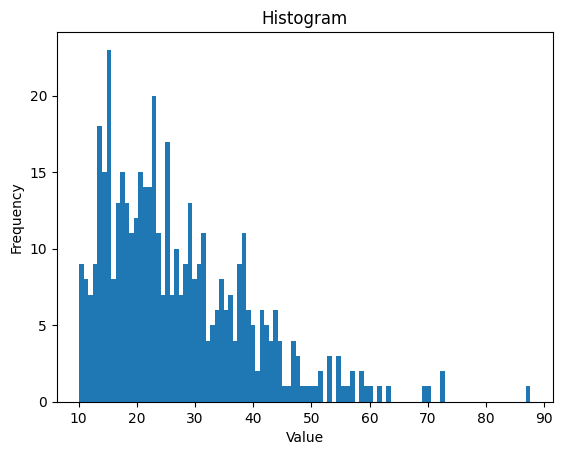

In [66]:
import matplotlib.pyplot as plt

# Generate histogram
plt.hist(kremling_expression_v5_denovo97_zeros_filtered.loc['Zm00001eb370180_T002'][kremling_expression_v5_denovo97_zeros_filtered.loc['Zm00001eb370180_T002'] > 10],
         bins=100)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

## Correlations with OTUs at 85% (de novo clustering)

In [67]:
wallace_asvs_q20_fw_denovo85_silva = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Qiime2/clustering/FeatureTable/denovo_85_q20_rv_feature-table.tsv',
                           sep='\t', comment='#')

# Rename column and reset the index
wallace_asvs_q20_fw_denovo85_silva.rename(columns={'OTU ID': 'Name'}, inplace=True)
wallace_asvs_q20_fw_denovo85_silva.set_index('Name', inplace=True)

# Print the dataframe
print(wallace_asvs_q20_fw_denovo85_silva.shape)
wallace_asvs_q20_fw_denovo85_silva.head(n=2)

(227, 592)


,SRR6665476,SRR6665477,SRR6665478,SRR6665479,SRR6665480,SRR6665481,SRR6665482,SRR6665483,SRR6665484,SRR6665485,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,SRR6666062,SRR6666063,SRR6666064,SRR6666065,SRR6666066,SRR6666067
Name,,,,,,,,,,,,,,,,,,,,,
16369bde74e9a431dd6dd237b3912350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c9f472c035f279182e74242c848a3392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# Rename the columns using the dictionary
wallace_asvs_q20_fw_denovo85_silva = wallace_asvs_q20_fw_denovo85_silva.rename(columns=run2my_sample_id)
wallace_asvs_q20_fw_denovo85_silva.columns = [str(x) for x in wallace_asvs_q20_fw_denovo85_silva.columns]

In [69]:
wallace_asvs_q20_fw_denovo85_silva.head()

,SRR6665476,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
16369bde74e9a431dd6dd237b3912350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c9f472c035f279182e74242c848a3392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232ad9e267688a5d573112b4855bac96,0.0,17150.0,113657.0,181791.0,166400.0,185588.0,32209.0,35833.0,64406.0,93505.0,...,59955.0,0.0,102025.0,53111.0,152534.0,195690.0,59885.0,0.0,0.0,98880.0
225bc1cb152b786927ca748b98403d94,0.0,445.0,17747.0,1673.0,15666.0,11841.0,1522.0,720.0,1104.0,5969.0,...,2458.0,0.0,1059.0,598.0,11127.0,8230.0,2751.0,0.0,0.0,608.0
3d1dbdd280105f11319d47dec1bbe01e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
kremling_expression_v5_denovo85 = kremling_expression_v5.filter(items=wallace_asvs_q20_fw_denovo85_silva.columns)

In [71]:
wallace_asvs_q20_fw_denovo85_silva = wallace_asvs_q20_fw_denovo85_silva.filter(items=kremling_expression_v5_denovo85.columns)

In [72]:
print(kremling_expression_v5_denovo85.shape)
kremling_expression_v5_denovo85.head()

(39096, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.349820,0.0,0.000000,0.0,0.000000,0.359664,0.541724,0.000000,0.00000,0.0,...,2.11575,1.24155,1.24528,0.00000,0.0,0.00000,0.808996,0.743690,3.42920,0.00000
Zm00001eb371350_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371330_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371310_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371280_T001,0.441188,0.0,0.215403,0.0,0.817563,2.351130,0.885315,0.517418,1.56597,0.0,...,2.99848,2.70535,2.00021,2.23636,0.0,2.35318,2.974720,0.911501,1.52984,4.15375


In [73]:
print(wallace_asvs_q20_fw_denovo85_silva.shape)
wallace_asvs_q20_fw_denovo85_silva.head()

(227, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
16369bde74e9a431dd6dd237b3912350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c9f472c035f279182e74242c848a3392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232ad9e267688a5d573112b4855bac96,17150.0,113657.0,181791.0,166400.0,185588.0,32209.0,35833.0,64406.0,93505.0,5310.0,...,0.0,0.0,0.0,17633.0,152534.0,195690.0,59885.0,0.0,0.0,98880.0
225bc1cb152b786927ca748b98403d94,445.0,17747.0,1673.0,15666.0,11841.0,1522.0,720.0,1104.0,5969.0,213.0,...,0.0,0.0,0.0,941.0,11127.0,8230.0,2751.0,0.0,0.0,608.0
3d1dbdd280105f11319d47dec1bbe01e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
if wallace_asvs_q20_fw_denovo85_silva.columns.all() == kremling_expression_v5_denovo85.columns.all():
    print('Columns are equal!')

Columns are equal!


In [75]:
wallace_asvs_q20_fw_denovo85_silva_zeros_filtered = count_zeros(wallace_asvs_q20_fw_denovo85_silva)
kremling_expression_v5_denovo85_zeros_filtered = count_zeros(kremling_expression_v5_denovo85)

Threshold: 241 (threshold * number of columns)
Threshold: 241 (threshold * number of columns)


In [76]:
print(wallace_asvs_q20_fw_denovo85_silva_zeros_filtered.shape)
print(kremling_expression_v5_denovo85_zeros_filtered.shape)

(5, 482)
(19953, 482)


In [77]:
wallace_asvs_q20_fw_denovo85_silva_zeros_filtered.index

Index(['232ad9e267688a5d573112b4855bac96', '225bc1cb152b786927ca748b98403d94',
       '3a3a197520db6ad8f425e4d0935e5f23', '343621515628bbb16a8aa3cfbf103abe',
       '9513fb99947860ebff7ca131f8cee160'],
      dtype='object', name='Name')

Taxonomy:

| ID | Taxonomy info |
|----|---------------|
| 232ad9e267688a5d573112b4855bac96 | d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas |
| 225bc1cb152b786927ca748b98403d94 | d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__Hymenobacteraceae; g__Hymenobacter |
| 9513fb99947860ebff7ca131f8cee160 | d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Weeksellaceae; g__Chryseobacterium |
| 3a3a197520db6ad8f425e4d0935e5f23 | d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Burkholderiales; f__Comamonadaceae |
| 343621515628bbb16a8aa3cfbf103abe | d__Bacteria; p__Actinobacteriota; c__Actinobacteria |